In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import gmtime, strftime
from datetime import date
from scipy import stats

4.1

In [2]:
df=pd.read_csv('ILINet_states.csv')

In [3]:
def weeknum(year,week):
    if year in long_year:
        if week <= 20:
            wknm = week+14
        else:
            wknm = week - 39
    else:
        if week <= 20:
            wknm = week + 13
        else:
            wknm = week - 39
    return int(wknm)

def write_season(year,week):
    if week <= 20:
        start = year-1
        end = year
        season = str(start)+'-'+str(end)
        return season
    elif week >= 40:
        start = year
        end = year+1
        season = str(start)+'-'+str(end)
        return season

def make_newdf(regiontype, region):
    ILI_sub = df.loc[(df['YEAR'] >= 2000) & (df['REGION TYPE'] == regiontype)&(df['REGION'] == region)][['YEAR','WEEK','%UNWEIGHTED ILI']]
    ILI_sub = ILI_sub.loc[(df['WEEK'] <= 20) | (df['WEEK'] >= 40)]
    ILI_sub['epiweek']=ILI_sub[['YEAR','WEEK']].apply(lambda x: weeknum(x.YEAR, x.WEEK), axis=1)
    ILI_sub['%UNWEIGHTED ILI'] = ILI_sub['%UNWEIGHTED ILI'].astype(float)
    drop = ILI_sub[(ILI_sub['YEAR'] == 2000)&(ILI_sub['epiweek']>13)].index
    ILI_sub.drop(drop,inplace=True)

    ILI_sub['season'] = ILI_sub[['YEAR','WEEK']].apply(lambda x: write_season(x.YEAR, x.WEEK), axis=1)
    return ILI_sub
long_year = df.loc[df['WEEK'] == 53][['YEAR']]['YEAR'].values.tolist()
short_year = df['YEAR'].values.tolist()
short_year = list(set(short_year).symmetric_difference(set(long_year)))

In [4]:
states_41 = make_newdf('States', 'Georgia')
states_41 = states_41[states_41['season']=="2018-2019"]


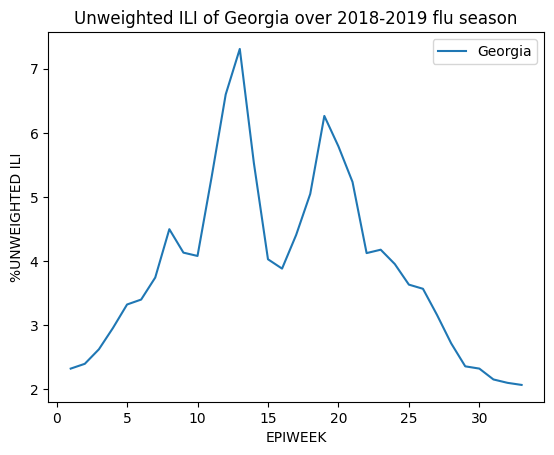

In [5]:
X=states_41['epiweek']
Y=states_41['%UNWEIGHTED ILI']
f = plt.figure()
plt.title('Unweighted ILI of Georgia over 2018-2019 flu season')
plt.plot(X,Y,label = 'Georgia')
plt.xlabel('EPIWEEK')
plt.ylabel('%UNWEIGHTED ILI')
plt.legend()
plt.savefig('4.1.png')

4.2

In [36]:
s18 =pd.read_csv('2018_symptoms_dataset.csv')
s19 =pd.read_csv('2019_weekly_symptoms_dataset.csv')
s = pd.concat([s18,s19])

In [124]:
def weeknum2(week):
    if week <= 20:
        wknm = week + 13
    else:
        wknm = week - 39
    return int(wknm)

In [123]:
def find_weeknum(date):
    d = time.strptime(date, "%Y-%m-%d")
    return d.isocalendar()[1]

def new_sdf (region):
    df=s[s['sub_region_1'] == region][['sub_region_1','date','symptom:Fever','symptom:Low-grade fever','symptom:Cough','symptom:Sore throat','symptom:Headache','symptom:Fatigue','symptom:Muscle weakness']]
    #select the interested symptoms, and convert the date to according week num and epiweek num
    df['date']=pd.to_datetime(df['date'])
    df["week"]=df['date'].dt.isocalendar().week.astype(int)
    df=df.drop(df.tail(1).index,inplace=False)

    df['epiweek'] = df['week'].apply(weeknum2)
    df = df[((df['date'].dt.year == 2019) & (df['week'] <=20))|((df['date'].dt.year == 2018)&(df['week'] >=40))]
    return df

In [103]:
Georgia_s = new_sdf('Georgia')

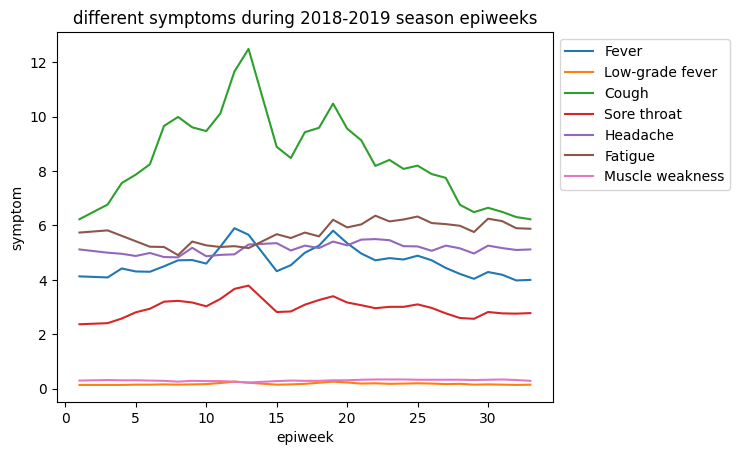

In [104]:
X = Georgia_s['epiweek']

plt.plot(X,Georgia_s['symptom:Fever'],label = 'Fever')
plt.plot(X,Georgia_s['symptom:Low-grade fever'],label = 'Low-grade fever')
plt.plot(X,Georgia_s['symptom:Cough'],label = 'Cough')
plt.plot(X,Georgia_s['symptom:Sore throat'],label = 'Sore throat')
plt.plot(X,Georgia_s['symptom:Headache'],label = 'Headache')
plt.plot(X,Georgia_s['symptom:Fatigue'],label = 'Fatigue')
plt.plot(X,Georgia_s['symptom:Muscle weakness'],label = 'Muscle weakness')
plt.title('different symptoms during 2018-2019 season epiweeks')
plt.xlabel('epiweek')
plt.ylabel('symptom')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('4.2.png')

4.3

In [106]:
pcc_df = states_41.merge(Georgia_s, on='epiweek',how='inner')
pcc_df=pcc_df.dropna(inplace=False)

In [107]:
x = pcc_df['%UNWEIGHTED ILI']
pcc_fever=stats.pearsonr(x, pcc_df['symptom:Fever'])[0]
pcc_lowgrade_fever=stats.pearsonr(x, pcc_df['symptom:Low-grade fever'])[0]
pcc_cough=stats.pearsonr(x, pcc_df['symptom:Cough'])[0]
pcc_throat=stats.pearsonr(x, pcc_df['symptom:Sore throat'])[0]
pcc_headache=stats.pearsonr(x, pcc_df['symptom:Headache'])[0]
pcc_fatique=stats.pearsonr(x, pcc_df['symptom:Fatigue'])[0]
pcc_muscle=stats.pearsonr(x, pcc_df['symptom:Muscle weakness'])[0]

In [108]:
symptom = ['Fever', 'Low-grade fever', 'Cough', 'Sore throat', 'Headache', 'Fatigue', 'Muscle weakness']
pcc =[pcc_fever,pcc_lowgrade_fever,pcc_cough,pcc_throat,pcc_headache,pcc_fatique,pcc_muscle]
newpcc = pd.DataFrame()
newpcc['symptom']  = symptom
newpcc['PCC']  = pcc
max_row = newpcc['PCC'].idxmax()
newpcc

,symptom,PCC
0,Fever,0.949919
1,Low-grade fever,0.828344
2,Cough,0.947621
3,Sore throat,0.889420
4,Headache,0.225429
5,Fatigue,-0.307975
6,Muscle weakness,-0.539034


4.4

In [115]:
def generate_pcc(state):
    states = make_newdf('States', state)
    states = states[states['season']=="2018-2019"]
    state_s = new_sdf(state)
    pcc_df = states.merge(state_s, on='epiweek',how='inner')
    pcc_df = pcc_df.dropna(inplace=False)
    x = pcc_df['%UNWEIGHTED ILI']
    pcc_fever=stats.pearsonr(x, pcc_df['symptom:Fever'])[0]
    pcc_lowgrade_fever=stats.pearsonr(x, pcc_df['symptom:Low-grade fever'])[0]
    pcc_cough=stats.pearsonr(x, pcc_df['symptom:Cough'])[0]
    pcc_throat=stats.pearsonr(x, pcc_df['symptom:Sore throat'])[0]
    pcc_headache=stats.pearsonr(x, pcc_df['symptom:Headache'])[0]
    pcc_fatique=stats.pearsonr(x, pcc_df['symptom:Fatigue'])[0]
    pcc_muscle=stats.pearsonr(x, pcc_df['symptom:Muscle weakness'])[0]
    symptom = ['Fever', 'Low-grade fever', 'Cough', 'Sore throat', 'Headache', 'Fatigue', 'Muscle weakness']
    pcc =[pcc_fever,pcc_lowgrade_fever,pcc_cough,pcc_throat,pcc_headache,pcc_fatique,pcc_muscle]
    newpcc = pd.DataFrame()
    newpcc['symptom']  = symptom
    newpcc['PCC']  = pcc
    max_row = newpcc['PCC'].idxmax()
    print(state+' Highest PCC symptom:',newpcc.iloc[newpcc['PCC'].idxmax()][0],', PCC value: ', newpcc.iloc[newpcc['PCC'].idxmax()][1])

In [116]:
generate_pcc('California')

California Highest PCC symptom: Cough , PCC value:  0.9602297157131077


In [117]:
generate_pcc('Texas')

Texas Highest PCC symptom: Low-grade fever , PCC value:  0.9662977722721163


In [118]:
generate_pcc('New York')

New York Highest PCC symptom: Low-grade fever , PCC value:  0.9632297029572723


In [119]:
generate_pcc('Alaska')

Alaska Highest PCC symptom: Cough , PCC value:  0.9672301858176479


In [120]:
generate_pcc('Mississippi')

Mississippi Highest PCC symptom: Fever , PCC value:  0.9329311476905453


The highest pcc symptoms are different across states. For these six states, cough, low-grade-fever, and fever each occupies two states. This may actually due to different variants of COVID (or flu variant) that is epidemic in that state, and different variants may lead to different significance of fever of symptoms.